In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.metrics import classification_metrics
from sklearn.ensemble import GradientBoostingClassifier as GBC
from scripts.data_load import preprocess_data, LOCAL_DATA_PATH
import seaborn as sns

sns.set(palette="colorblind")
%matplotlib inline

In [2]:
feature_transformer, (X_train, y_train), (X_val, y_val), (X_test, y_test) = preprocess_data(data_path=LOCAL_DATA_PATH)

In [3]:
clf = GBC()
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
naive_results = classification_metrics(y_val, y_val_pred)
naive_results

{'accuracy_score': 0.9672078955746578,
 'precision_score': np.float64(0.9627994955863808),
 'recall_score': np.float64(0.9719923615531508),
 'f1_score': np.float64(0.9673740893253089)}

The performance of the gradient boosting is around 96% on validation set lagging behind SVC

Let's analyzer how number of weak estimators and the depth of each estimator affects train vs validation results

In [4]:
max_depths = [1, 2, 4, 8, 16]
num_estimators = [2, 16, 32, 64, 128, 256]


train_accuracy_history = dict()
val_accuracy_history = dict()

train_precision_history = dict()
val_precision_history = dict()

train_recall_history = dict()
val_recall_history = dict()

train_f1score_history = dict()
val_f1score_history = dict()

for max_depth in max_depths:
    print(f"Processing trees with max_depth={max_depth}")
    train_accuracy_history[max_depth] = []
    val_accuracy_history[max_depth] = []

    train_precision_history[max_depth] = []
    val_precision_history[max_depth] = []

    train_recall_history[max_depth] = []
    val_recall_history[max_depth] = []

    train_f1score_history[max_depth] = []
    val_f1score_history[max_depth] = []

    for num_estimator in num_estimators:
        clf = GBC(n_estimators=num_estimator, max_depth=max_depth)
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_val_pred = clf.predict(X_val)
        train_results = classification_metrics(y_train, y_train_pred)
        val_results = classification_metrics(y_val, y_val_pred)

        train_accuracy_history[max_depth].append(train_results['accuracy_score'])
        val_accuracy_history[max_depth].append(val_results['accuracy_score'])

        train_precision_history[max_depth].append(train_results['precision_score'])
        val_precision_history[max_depth].append(val_results['precision_score'])

        train_recall_history[max_depth].append(train_results['recall_score'])
        val_recall_history[max_depth].append(val_results['recall_score'])

        train_f1score_history[max_depth].append(train_results['f1_score'])
        val_f1score_history[max_depth].append(val_results['f1_score'])

Processing trees with max_depth=1
Processing trees with max_depth=2
Processing trees with max_depth=4
Processing trees with max_depth=8
Processing trees with max_depth=16


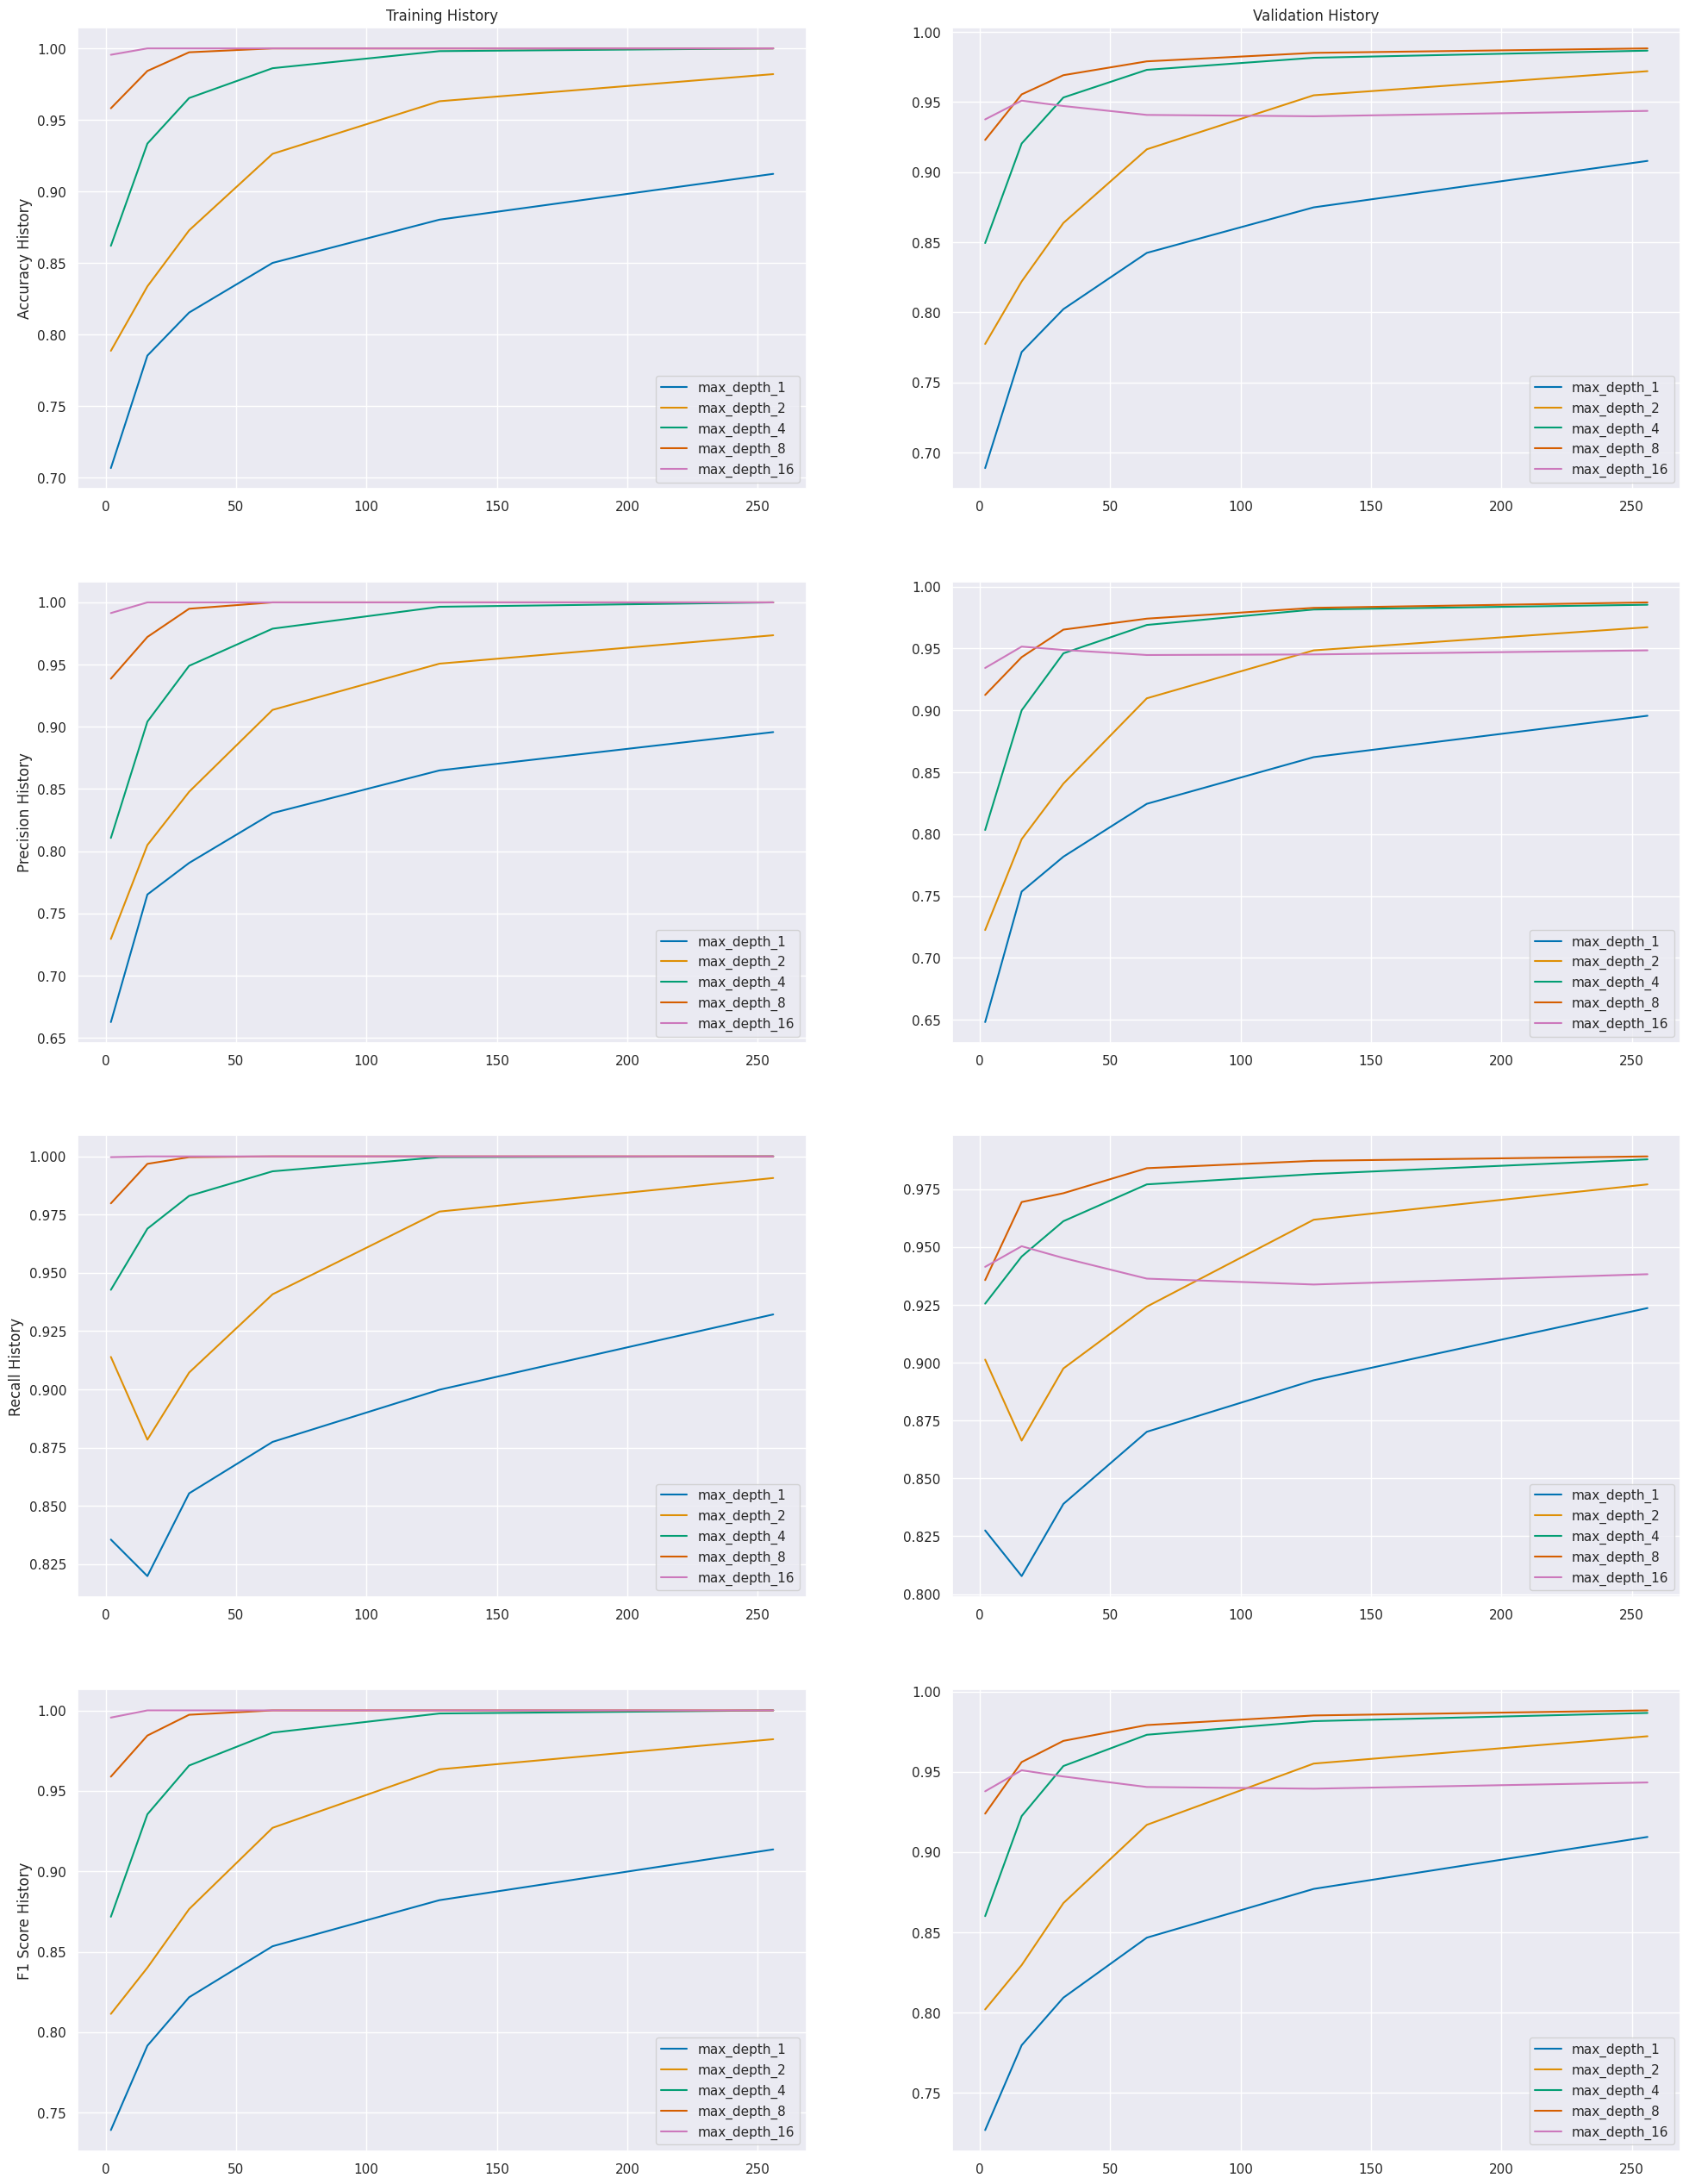

In [7]:
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(24, 32))

for max_depth in max_depths:
    axis[0, 0].set_ylabel("Accuracy History")
    axis[0, 0].set_title("Training History")
    axis[1, 0].set_ylabel("Precision History")
    axis[0, 1].set_title('Validation History')
    axis[2, 0].set_ylabel("Recall History")
    axis[3, 0].set_ylabel("F1 Score History")
    axis[0, 0].plot(num_estimators, train_accuracy_history[max_depth], label=f'max_depth_{max_depth}')
    axis[1, 0].plot(num_estimators, train_precision_history[max_depth], label=f'max_depth_{max_depth}')
    axis[2, 0].plot(num_estimators, train_recall_history[max_depth], label=f'max_depth_{max_depth}')
    axis[3, 0].plot(num_estimators, train_f1score_history[max_depth], label=f'max_depth_{max_depth}')


    axis[0, 1].plot(num_estimators, val_accuracy_history[max_depth], label=f'max_depth_{max_depth}')
    axis[1, 1].plot(num_estimators, val_precision_history[max_depth], label=f'max_depth_{max_depth}')
    axis[2, 1].plot(num_estimators, val_recall_history[max_depth], label=f'max_depth_{max_depth}')
    axis[3, 1].plot(num_estimators, val_f1score_history[max_depth], label=f'max_depth_{max_depth}')



axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
axis[2, 0].legend()
axis[2, 1].legend()
axis[3, 0].legend()
axis[3, 1].legend()
plt.show()

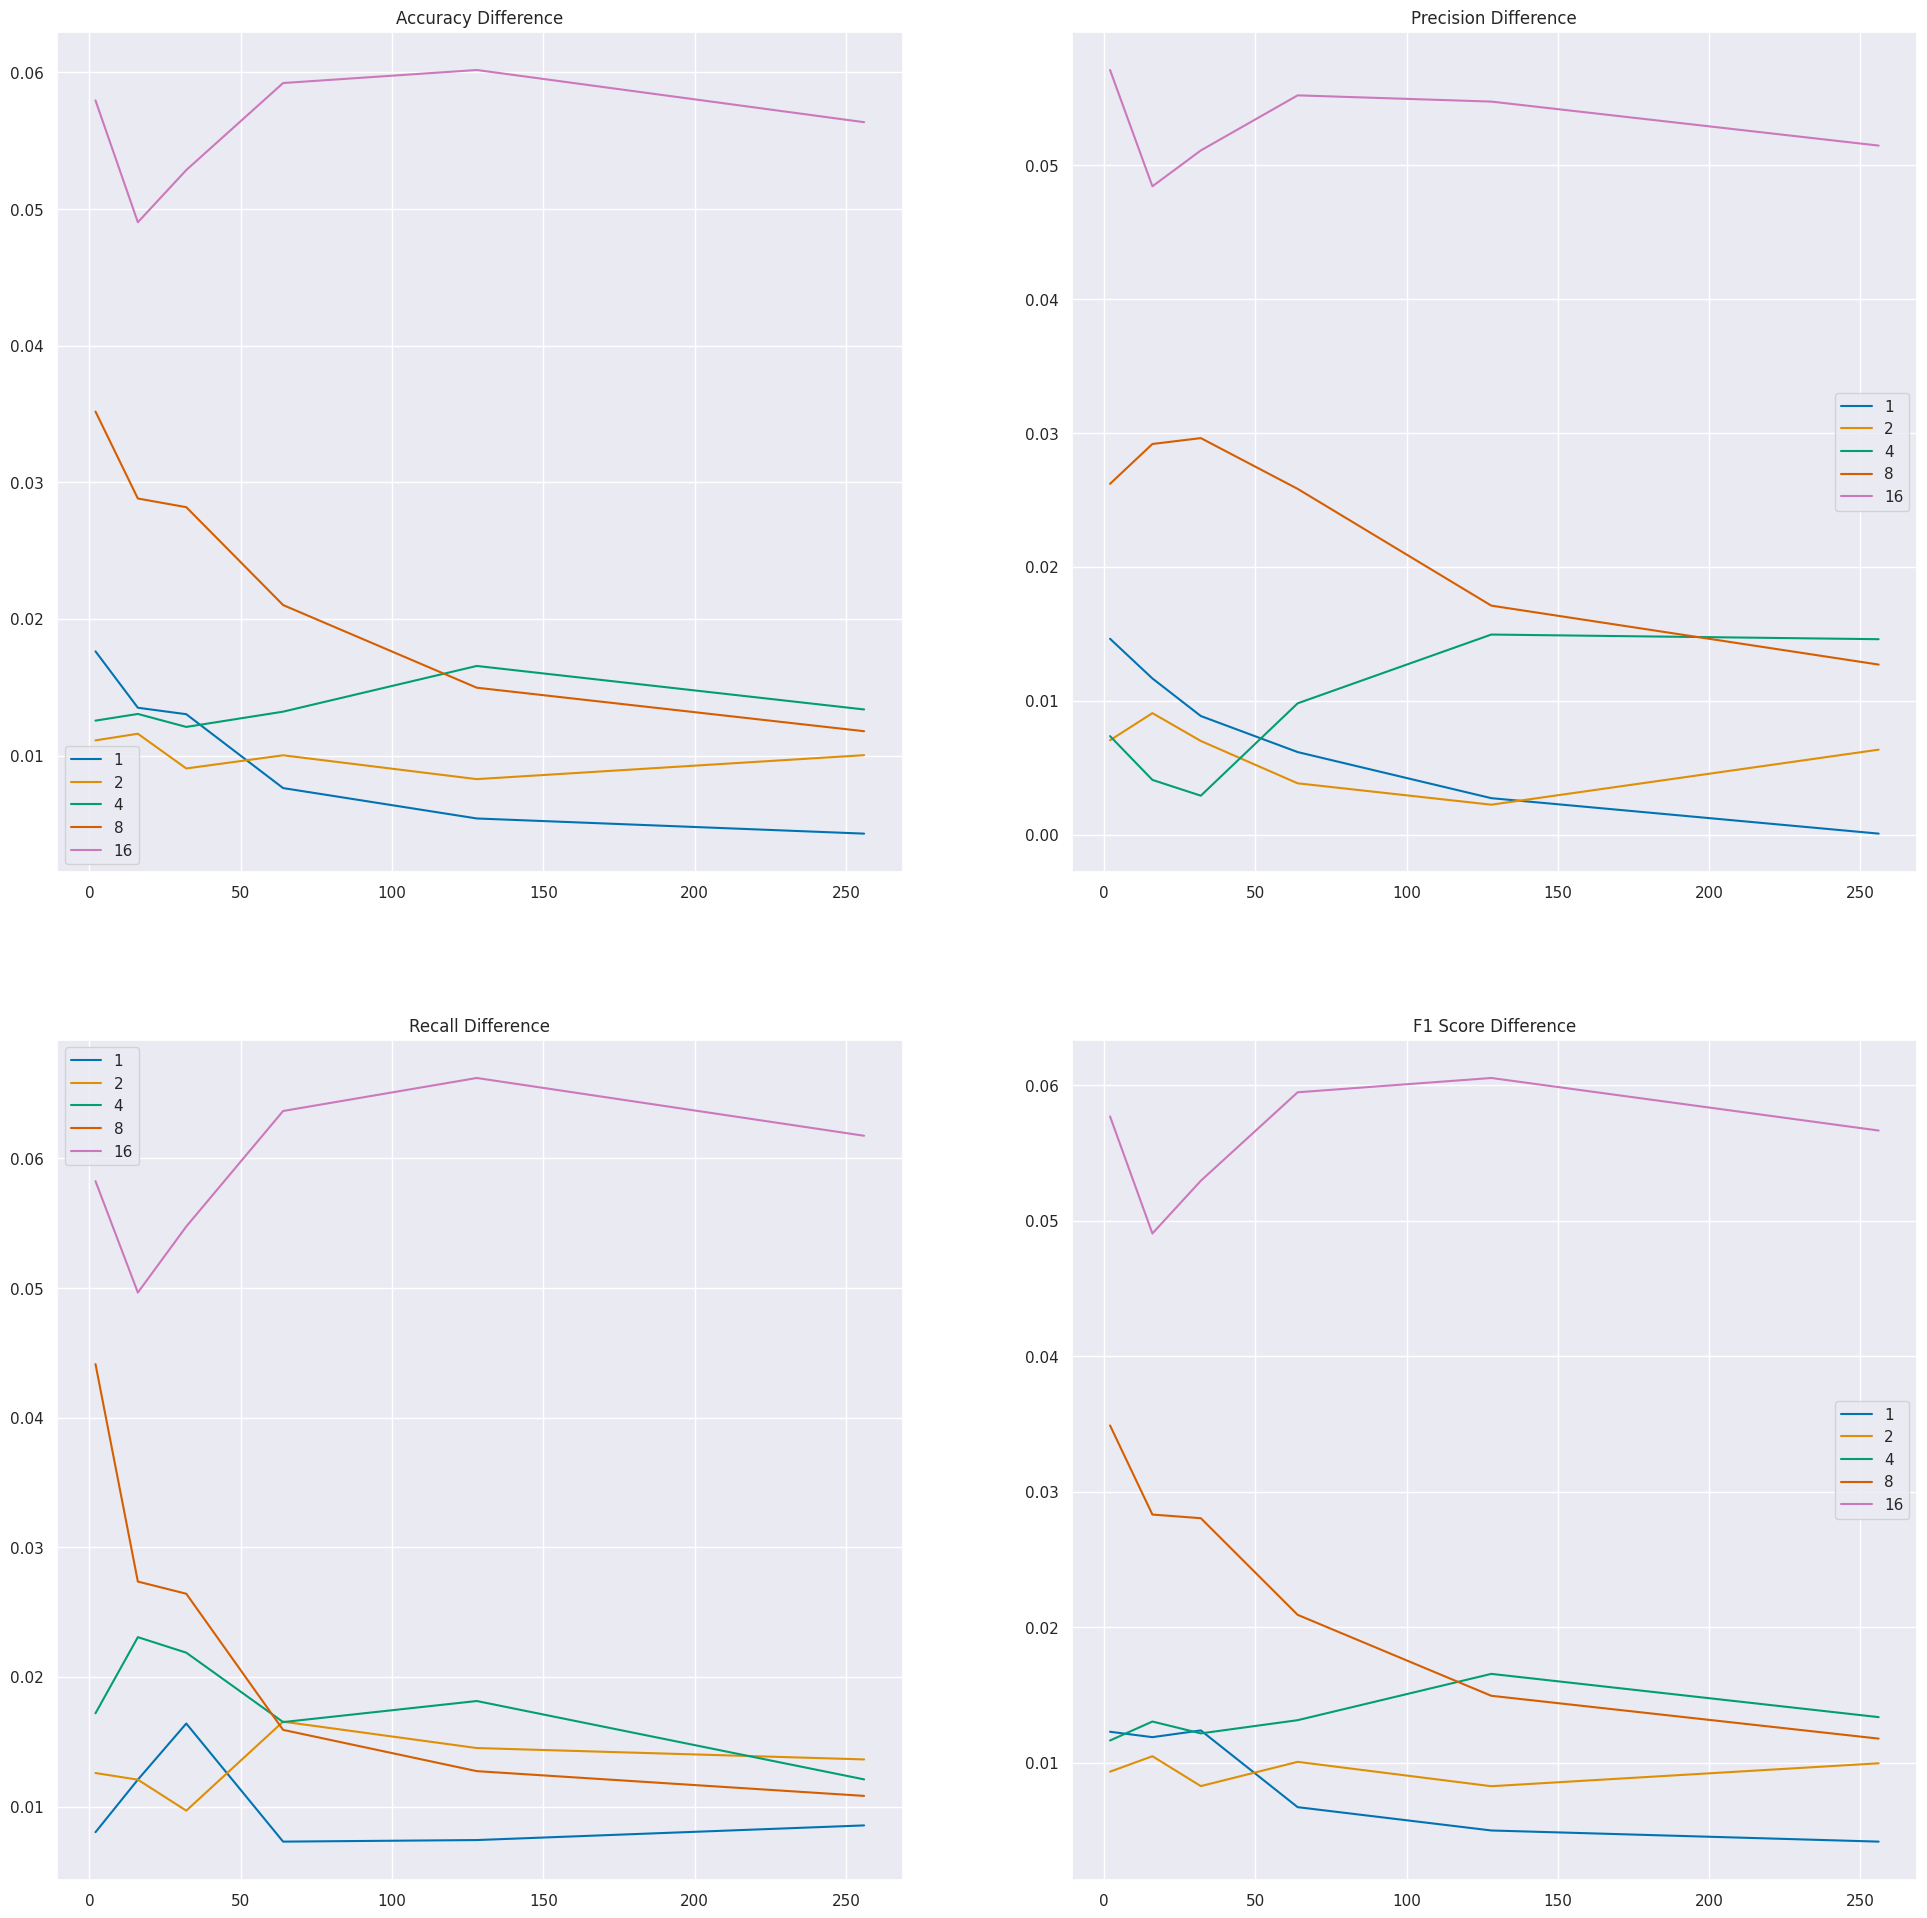

In [8]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(24, 24))

for max_depth in max_depths:

    axis[0, 0].plot(num_estimators, np.array(train_accuracy_history[max_depth])-
                    np.array(val_accuracy_history[max_depth]), label=max_depth)
    axis[0, 0].set_title("Accuracy Difference")

    axis[0, 1].plot(num_estimators, np.array(train_precision_history[max_depth])-
                    np.array(val_precision_history[max_depth]), label=max_depth)
    axis[0, 1].set_title("Precision Difference")

    axis[1, 0].plot(num_estimators, np.array(train_recall_history[max_depth])-
                    np.array(val_recall_history[max_depth]), label=max_depth)
    axis[1, 0].set_title("Recall Difference")

    axis[1, 1].plot(num_estimators, np.array(train_f1score_history[max_depth])-
                    np.array(val_f1score_history[max_depth]), label=max_depth)
    axis[1, 1].set_title("F1 Score Difference")

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()

plt.show()

We observed that Gradient Boosting Classifier with 'num_estimators'=128 and 'max_depth'=8 performs best on the validation set and thus we will test that specific setup. For 'num_estimators'>=128, performance is flat and doesn't improve

In [9]:
clf = GBC(n_estimators=128, max_depth=8)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
test_results = classification_metrics(y_test, y_test_pred)
test_results

{'accuracy_score': 0.9881154499151104,
 'precision_score': np.float64(0.9890848026868178),
 'recall_score': np.float64(0.9874266554903605),
 'f1_score': np.float64(0.988255033557047)}

Now, let's visualize the performance of the model on Principal data components

In [10]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
pca_model.fit(X_train)
x_test_pca = pca_model.transform(X_test)
print(pca_model.explained_variance_ratio_)
print(pca_model.singular_values_)

[0.28464515 0.1630401 ]
[171.4091066  129.72665529]


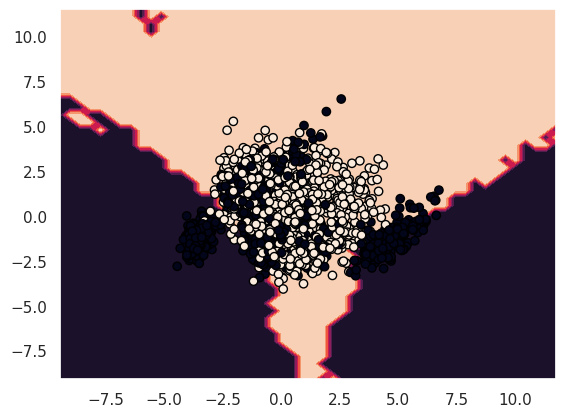

In [11]:
from sklearn.inspection import DecisionBoundaryDisplay

feature_1, feature_2 = np.meshgrid(
    np.linspace(x_test_pca[:, 0].min()-5, x_test_pca[:, 0].max()+5),
    np.linspace(x_test_pca[:, 1].min()-5, x_test_pca[:, 1].max()+5))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
latent_grid = pca_model.inverse_transform(grid)
y_pred = np.reshape(clf.predict(latent_grid), feature_1.shape)

display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, 
                                  response=y_pred)
display.plot()

display.ax_.scatter(x_test_pca[:, 0], x_test_pca[:, 1], 
                    c=y_test, edgecolor="black")
plt.show()

Decision boundary for Gradient Boosting Classifier is clearly separating fakes from real in outer regions better, which might be desirable for out-of-distribution generalization

Certainly, generalization performance on a test set is much higher than Ridge Classifier while performing on par with the Support Vector Classifier. We have decided to continue with SVC for deployment